# Análise de sentimento do Twitter

Abaixo foi aplicado os seguintes algoritmos: LogisticRegression, LinearSVC, MultinomialNB, RandomForestClassifier e a combinação de todos estes algoritmos (Ensemble). Todos eles foram aplicados para o problema de classifição de Twitters.

Primeiro vamos começar carregando as blibiotecas principais

In [103]:
import nltk
nltk.download('stopwords')

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from mlxtend.plotting import plot_decision_regions
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirellebueno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Agora vamos importar nossa base de treinamento. Esta base foi obtida em:https://www.kaggle.com/leandrodoze/sentiment-analysis-in-portuguese É um dataset com 8.199 amostras de twitters na linguagem Português.

In [2]:
dataset = pd.read_csv('../Tweets_Mg.csv',encoding='utf-8')

Vamos dar uma checkada na distribução de classes da nossa base

In [94]:
dataset.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


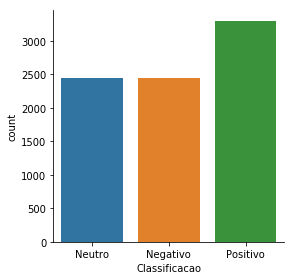

In [100]:
sns.factorplot('Classificacao', data=dataset, kind='count')

Vamos Separar os textos das classes

In [3]:
tweets =dataset["Text"].values
target = dataset["Classificacao"].values

# Etapa 1 - Limpeza 

Agora vem a parte que eu considero uma das mais importantes: A limpeza do dataset, afinal, garbage in garbage out!
Basicamente, primeiro transformo o texto todo em minusculo e depois retiro alguns caracteres especiais que podem confundir nosso classificador.


In [4]:
dataset['Text'].str.lower()

tweets=dataset['Text'].replace(['^a-zA-Z0-9ÀÁÂÃÄÅÇÈÉÊËÌÍÎÏÒÓÔÕÖÙÚÛÜÝàáâãäåçèéêëìíîïðòóôõöùúûüýÿ,!?\'\`\.\(\)'],[""],regex=True)
tweets=dataset['Text'].replace(['INC[0-9]{7,}'],[" <INCIDENTE> "],regex=True)
tweets=dataset['Text'].replace(['[+-]?\d+(?:\.\d+)?'],[" <NUMERO> "],regex=True)
tweets=dataset['Text'].replace(['!'],[" ! "],regex=True)
tweets=dataset['Text'].replace(['\('],[" ( "],regex=True)
tweets=dataset['Text'].replace(['\)'],[" ) "],regex=True)
tweets=dataset['Text'].replace(['\?'],[" ? "],regex=True)
tweets=dataset['Text'].replace(['\s{2,}'],[" "],regex=True)
tweets=dataset['Text'].replace("..","")
tweets=dataset['Text'].replace('"', "")
tweets=dataset['Text'].replace("''", "")
tweets=dataset['Text'].replace("p/", "")
tweets=dataset['Text'].replace("RT ", "")

Ainda nesta etapa de limpeza eu recupero todos os "stop words". Os stop words,assim como o nome já diz, são palavras de parada, como por exemplo "de, a, em, entretanto" e etc, eu prefiro tirar devido a trabalhos na literatura que demostram ganhos de performace com a retirada dos mesmos.

In [109]:
stopwords = nltk.corpus.stopwords.words('portuguese')

# Etapa 2 - Transformação

A próxima etapa, é de transformação de dados, que faz parte do pré-processamento. A transformação de dados neste problema que estamos tratando, é transformar as palavras em número e como fazemos isso? Transformamos as palavras em uma grande matriz/vetor de 0 e 1

In [6]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2),stop_words=stopwords)
vectorizer.fit(tweets)

X_tranform_vector = vectorizer.transform(tweets)

ngram_range:  Estou pedindo para que ele tranforme a cada duas palvras, por exemplo, a frase: Eu gosto de cachorro, nossa função irá mandar {eu gosto,de cachorro}. Esta decisão foi devido a relatos de ganhos de desempenho na literatura.

# Etapa 3 - Treinando e avaliando os modelos

##  Logistic Regression

 Um dos motivos pela escolha dos modelos de Regressão lógica são por serem  mais fáceis de interpretar e assim como os modelos lineares, aprendem rapidamente e com resultados satisfatórios. Antes de o treinar definitivamente, devemos encontrar o melhor coeficiente de regularização, que nos traga mais ganhos, que neste caso por meio da acurácia.

In [7]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lR = LogisticRegression(C=c)
    lR.fit(X_tranform_vector, target)
    print ("Accuracy for C=%s: %s"% (c, accuracy_score(target, lR.predict(X_tranform_vector))))
    

Accuracy for C=0.01: 0.9323088181485547
Accuracy for C=0.05: 0.9681668496158068
Accuracy for C=0.25: 0.9904866447127698
Accuracy for C=0.5: 0.995853152823515
Accuracy for C=1: 0.9971947798512014


### Treinamento

O Melhor valor de C é 1. Vamos treinar nosso classificador com este valor.

In [8]:
model_logistic_regression= LogisticRegression(C=1)
model_logistic_regression.fit(X_tranform_vector, target)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Avaliação do Modelo

Para a avaliação do nosso modelo, eu escolhi o método "Cross Validation". De acordo com a literatura ele é um dos melhores métodos para avaliar a capacidade de generalização do modelo. Aqui eu dividi nosso dataset em 10 partições.

In [9]:
result_validation = cross_val_predict(model_logistic_regression, X_tranform_vector , target, cv = 10)

metrics.accuracy_score(target, result_validation)

0.8934016343456519

Porém, devido ao fato de que a acurácia ser problematica(ruidos,desbalanceamento etc..), precisamos ter uma visão geral dos erros do nosso classificador, para isso a função "metrics.classification_report" nos traz um detalhamento dos erros, alem disso, o método crosstab nos traz a matriz de confusão

In [111]:
metrics.classification_report(target, result_validation, ["Positivo", "Negativo", "Neutro"])

'             precision    recall  f1-score   support\n\n   Positivo       0.96      0.88      0.92      3300\n   Negativo       0.92      0.92      0.92      2446\n     Neutro       0.80      0.88      0.84      2453\n\navg / total       0.90      0.89      0.89      8199\n'

In [112]:
pd.crosstab(target, result_validation, rownames = ["Real"], colnames=["Predito"], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,2256,181,9,2446
Neutro,188,2161,104,2453
Positivo,19,373,2908,3300
All,2463,2715,3021,8199


## Linear SVC

O modelo Linear SVC também foi escolhido com base nos críterios do modelo anterior

Assim como para o modelo Logist Regression, precisamos definir um valor para C

In [12]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    linearSVC_model = LinearSVC(C=c)
    linearSVC_model.fit(X_tranform_vector, target)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(target, linearSVC_model.predict(X_tranform_vector))))

Accuracy for C=0.01: 0.9841444078546164
Accuracy for C=0.05: 0.9962190511037932
Accuracy for C=0.25: 0.9985364068788877
Accuracy for C=0.5: 0.9986583729723137
Accuracy for C=1: 0.9986583729723137


Os melhores valores de C são: 0.5 e 1. Ficaremos com o valor 0.5

### Treinamento 

In [13]:
model_linear_SVC= LinearSVC(C=0.5)
model_linear_SVC.fit(X_tranform_vector, target)

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Avaliação

In [14]:
result_validation_model_linear_svc = cross_val_predict(model_linear_SVC, X_tranform_vector , target, cv = 10)

metrics.accuracy_score(target, result_validation_model_linear_svc)



0.8962068544944506

In [15]:

metrics.classification_report(target, result_validation_model_linear_svc, ["Positivo", "Negativo", "Neutro"])


'             precision    recall  f1-score   support\n\n   Positivo       0.97      0.87      0.91      3300\n   Negativo       0.93      0.92      0.93      2446\n     Neutro       0.79      0.91      0.85      2453\n\navg / total       0.90      0.90      0.90      8199\n'

In [16]:
pd.crosstab(target, result_validation_model_linear_svc, rownames = ["Real"], colnames=["Predito"], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,2259,168,19,2446
Neutro,142,2233,78,2453
Positivo,19,425,2856,3300
All,2420,2826,2953,8199


Podemos perceber que ambos os modelos apresentaram valores de acurácia e de F1 Score semelhantes

## Multinomial Naive Bayes

Agora vamos repetir o mesmo processo para o classificador: MultinomialNB. O Classificador Naive bayes, por ser um classificador probabilístico, tem um grande desempenho para processamento de grandes bases de dados e seu metodo de aprendizado, apesar de simples, é eficaz!

### Treinamento

In [17]:
model_multinomialNB = MultinomialNB()
model_multinomialNB.fit(X_tranform_vector, target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Avaliação

In [18]:
result_validation_model_MultinomialNB = cross_val_predict(model_multinomialNB, X_tranform_vector , target, cv = 10)

metrics.accuracy_score(target, result_validation_model_MultinomialNB)

0.8963288205878766

In [117]:

metrics.classification_report(target, result_validation_model_MultinomialNB, ["Positivo", "Negativo", "Neutro"])

'             precision    recall  f1-score   support\n\n   Positivo       0.97      0.87      0.92      3300\n   Negativo       0.90      0.94      0.92      2446\n     Neutro       0.81      0.89      0.85      2453\n\navg / total       0.90      0.90      0.90      8199\n'

In [20]:
pd.crosstab(target, result_validation_model_MultinomialNB, rownames = ["Real"], colnames=["Predito"], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,2293,149,4,2446
Neutro,185,2188,80,2453
Positivo,63,369,2868,3300
All,2541,2706,2952,8199


## Random Forest

Faz parte do conjunto dos algoritmos de árvore de decisão, apesar de terem um custo computacional mais elevado dos algoritmos que estamos trabalhando até agora, ele apresenta a capacidade de gerar regras de classificação que para análises futuras são importante

### Treinamento

In [116]:
model_Random_Forest = RandomForestClassifier(n_estimators = 100)
model_Random_Forest.fit(X_tranform_vector, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Avaliação

In [120]:
result_valitation_Random_forest = cross_val_predict(model_Random_Forest, X_tranform_vector , target, cv = 10)



In [121]:
metrics.accuracy_score(target, result_valitation_Random_forest)

0.8762044151725821

In [122]:

metrics.classification_report(target, result_valitation_Random_forest, ["Positivo", "Negativo", "Neutro"])

'             precision    recall  f1-score   support\n\n   Positivo       0.97      0.82      0.89      3300\n   Negativo       0.96      0.89      0.92      2446\n     Neutro       0.73      0.94      0.82      2453\n\navg / total       0.90      0.88      0.88      8199\n'

In [123]:

 

pd.crosstab(target, result_valitation_Random_forest, rownames = ["Real"], colnames=["Predito"], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,2173,271,2,2446
Neutro,65,2296,92,2453
Positivo,15,570,2715,3300
All,2253,3137,2809,8199


## Multilayer Perceptron (MLP)

Para finalizar a aplicação dos classificadores clássicos, vamos aplicar ao nosso problema uma simple MPL com 5 neurônios na camada oculta, com uma entrada e uma saida.

### Treinamento

In [124]:
model_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

In [125]:
 model_MLP.fit(X_tranform_vector, target)  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Avaliação

In [126]:
result_valitation_MLP = cross_val_predict(model_MLP, X_tranform_vector , target, cv = 10)

In [127]:
metrics.accuracy_score(target, result_valitation_MLP)

0.8640078058299793

In [128]:
metrics.classification_report(target, result_valitation_MLP, ["Positivo", "Negativo", "Neutro"])

'             precision    recall  f1-score   support\n\n   Positivo       0.95      0.84      0.89      3300\n   Negativo       0.92      0.89      0.90      2446\n     Neutro       0.73      0.87      0.80      2453\n\navg / total       0.88      0.86      0.87      8199\n'

In [129]:
pd.crosstab(target, result_valitation_MLP, rownames = ["Real"], colnames=["Predito"], margins=True)

Predito,Negativo,Neutro,Positivo,All
Real,,,,
Negativo,2180,261,5,2446
Neutro,186,2133,134,2453
Positivo,13,516,2771,3300
All,2379,2910,2910,8199


## Visão Geral

Agora que temos nossos modelos treinados e avaliados, vamos ter uma visão geral sobre o desempenho deles, estou considerado a acurácia e o F1 Score como medidas de avalição principal. F1 score, pois, ele traz a porcentagem do real acerto das classes não sendo muito influenciado por ruidos em comparação a acurácia

LR: 0.884633 (0.154474)
SVC: 0.872558 (0.167261)
NB: 0.888535 (0.121697)
Random Forest: 0.856581 (0.172242)
MLP: 0.871583 (0.168364)


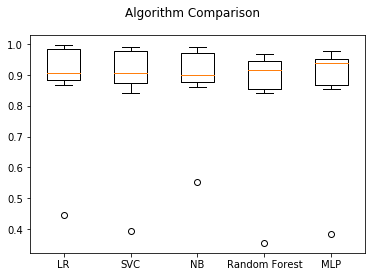

In [177]:
names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Random Forest', 'MLP']
results = [result_validation,result_validation_model_linear_svc,result_validation_model_MultinomialNB,result_valitation_Random_forest,result_valitation_MLP]

models = []
models.append(('LR', LogisticRegression(C=1)))
models.append(('SVC', LinearSVC(C=0.5)))
models.append(('NB', MultinomialNB()))
models.append(('Random Forest', RandomForestClassifier(n_estimators = 100)))
models.append(('MLP',MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)))
#models.append(('Esemble',VotingClassifier(models)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=7)
	cv_results = model_selection.cross_val_score(model, X_tranform_vector, target, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Como podemos ver, os classificadores obteram resultados semelhantes, sendo que o classificador Naive Bayes e Logistic Regression apresentaram  os melhores resultados.  Como todos os classificadores apresentaram resultados semelhante, seria interessante aplicarmos um Ensemble. Além disso, temos classificadores de arquiteturas diferentes trabalhando sobre o mesmo problema e apresentando resultados consideraveis.

## Ensemble

In [178]:
ensemble = VotingClassifier(models)
results_ensemble = model_selection.cross_val_score(ensemble, X_tranform_vector, target, cv=kfold)
print(results_ensemble.mean())


C:\Users\Mirellebueno\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Mirellebueno\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Mirellebueno\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Mirellebueno\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambig

0.8817053813395276


C:\Users\Mirellebueno\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


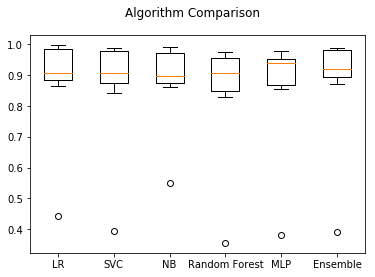

In [134]:

results.append(results_ensemble)
names.append('Ensemble')

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Nosso ensemble apresentou resultados semelhantes ao outros classificadores, sendo superior aos classificadores: Random Florest e Linear SVC e a rede Multilayer perceptron (MLP). Eu concluo que é interessante aplicarmos ele ao problema de análise de sentimento, devido a esses resultados e pelo fato de trazer maior generalização para a classificação

## Etapa 4 - Conclusão

Para o problema de análise de sentimento utilizando Twitters, foi realizado as etapas de limpeza, tranformação dos dados, treinamento e avaliação dos modelos propostos. Foi concluído que aplicação de um ensemble como classificador é interessante, devido aos resultados e sua forma de generalização, já que utiliza o voto de todos os classificadores vistos e aplicados.